In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib as plt
%matplotlib inline
exec(open(os.path.join(os.environ["SPARK_HOME"], 'python/pyspark/shell.py')).read())

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 2.4.4
      /_/

Using Python version 3.7.4 (default, Aug 13 2019 15:17:50)
SparkSession available as 'spark'.


In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkFiles
from pyspark.sql import DataFrameReader
from pyspark.sql.functions import to_timestamp
from pyspark.sql.functions import col
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark.sql.types import *

In [53]:
spark = SparkSession \
    .builder \
    .appName('pyspark_demo_app') \
    .config('spark.driver.extraClassPath',
            'postgresql-42.2.9') \
    .master("local[*]") \
    .getOrCreate()

In [54]:
# tips on jdbc ... https://sparkour.urizone.net/recipes/using-jdbc/#03
# Load properties from file
import json
with open("../data-load/Resources/db-properties.json") as propertyFile:
    properties = json.load(propertyFile)

dbMode = "overwrite"
jdbc_url= properties["jdbcUrl"]
dbConfig = {"user": properties["user"], 
          "password": properties["password"], 
          "driver": properties["driver"]
         }

In [55]:
entireDF = spark.read.jdbc(url=jdbc_url, table = 'heart_cardio_train', properties=dbConfig)
entireDF.printSchema()
entireDF.limit(5).show()

root
 |-- id: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- height: integer (nullable = true)
 |-- weight: double (nullable = true)
 |-- ap_hi: integer (nullable = true)
 |-- ap_lo: integer (nullable = true)
 |-- cholesterol: integer (nullable = true)
 |-- gluc: integer (nullable = true)
 |-- smoke: integer (nullable = true)
 |-- alco: integer (nullable = true)
 |-- active: integer (nullable = true)
 |-- cardio: integer (nullable = true)
 |-- age_yrs: integer (nullable = true)
 |-- weight_lbs: double (nullable = true)
 |-- height_inches: double (nullable = true)
 |-- bmi: double (nullable = true)

+-----+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+-------+------------------+-------------+------------------+
|   id|  age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|age_yrs|        weight_lbs|height_inches|               bmi|
+-----+-----+------+------+------+---

In [56]:
#convert to pandas df
heart_cardio = entireDF.select("*").toPandas()
heart_cardio.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_yrs,weight_lbs,height_inches,bmi
0,84851,23386,2,162,84.0,160,90,1,1,0,0,1,0,64,185.18808,63.779562,51.851852
1,84852,19540,1,164,83.0,120,80,1,1,0,0,1,0,53,182.98346,64.566964,50.609756
2,84853,20192,1,158,77.0,100,70,1,1,0,0,1,0,55,169.75574,62.204758,48.734177
3,84854,15406,1,163,61.0,140,90,1,1,0,0,1,1,42,134.48182,64.173263,37.423313
4,84857,17632,1,152,80.0,140,90,2,1,0,0,1,1,48,176.36960,59.842552,52.631579


In [57]:
heart_cardio=heart_cardio.drop(columns=['id','age', 'height','weight'], axis=1)
heart_cardio.head()

,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_yrs,weight_lbs,height_inches,bmi
0,2,160,90,1,1,0,0,1,0,64,185.18808,63.779562,51.851852
1,1,120,80,1,1,0,0,1,0,53,182.98346,64.566964,50.609756
2,1,100,70,1,1,0,0,1,0,55,169.75574,62.204758,48.734177
3,1,140,90,1,1,0,0,1,1,42,134.48182,64.173263,37.423313
4,1,140,90,2,1,0,0,1,1,48,176.36960,59.842552,52.631579


In [58]:
#Rename columns
heart_cardio=heart_cardio.rename(columns={"ap_hi": "systolic pressure", "ap_lo": "diastolic pressure", "alco": "alcohol"})
heart_cardio.head()

,gender,systolic pressure,diastolic pressure,cholesterol,gluc,smoke,alcohol,active,cardio,age_yrs,weight_lbs,height_inches,bmi
0,2,160,90,1,1,0,0,1,0,64,185.18808,63.779562,51.851852
1,1,120,80,1,1,0,0,1,0,53,182.98346,64.566964,50.609756
2,1,100,70,1,1,0,0,1,0,55,169.75574,62.204758,48.734177
3,1,140,90,1,1,0,0,1,1,42,134.48182,64.173263,37.423313
4,1,140,90,2,1,0,0,1,1,48,176.36960,59.842552,52.631579


In [59]:
#Drop rest of the features and create new df
feature_selected_df = heart_cardio.drop(['smoke', 'alcohol','height_inches'], axis=1)
feature_selected_df.head()

,gender,systolic pressure,diastolic pressure,cholesterol,gluc,active,cardio,age_yrs,weight_lbs,bmi
0,2,160,90,1,1,1,0,64,185.18808,51.851852
1,1,120,80,1,1,1,0,53,182.98346,50.609756
2,1,100,70,1,1,1,0,55,169.75574,48.734177
3,1,140,90,1,1,1,1,42,134.48182,37.423313
4,1,140,90,2,1,1,1,48,176.36960,52.631579


In [60]:
#Check duplicate values
print("There is {} duplicated values in data frame".format(feature_selected_df.duplicated().sum()))


There is 3575 duplicated values in data frame


In [61]:
#Drop duplicate values
feature_selected_df.drop_duplicates(inplace=True)
print("There is {} duplicated values in data frame".format(feature_selected_df.duplicated().sum()))

There is 0 duplicated values in data frame


In [52]:
# duplicated = feature_selected_df.duplicated[feature_selected_df.duplicated(keep=False)]
# # duplicated = duplicated.sort_values(by=['age_yrs'], ascending= False) 
# # sorted the values to see duplication clearly

# duplicated.head(2) # Show us just 1 duplication of 24

In [62]:
#Processing categorical features
dataset = pd.get_dummies(feature_selected_df, columns = ['active','cholesterol','gender','gluc'])
dataset.head()

,systolic pressure,diastolic pressure,cardio,age_yrs,weight_lbs,bmi,active_0,active_1,cholesterol_1,cholesterol_2,cholesterol_3,gender_1,gender_2,gluc_1,gluc_2,gluc_3
0,160,90,0,64,185.18808,51.851852,0,1,1,0,0,0,1,1,0,0
1,120,80,0,53,182.98346,50.609756,0,1,1,0,0,1,0,1,0,0
2,100,70,0,55,169.75574,48.734177,0,1,1,0,0,1,0,1,0,0
3,140,90,1,42,134.48182,37.423313,0,1,1,0,0,1,0,1,0,0
4,140,90,1,48,176.36960,52.631579,0,1,0,1,0,1,0,1,0,0


In [63]:
#Scaling continuous features using StandardScaler
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()
columns_to_scale = ['age_yrs', 'bmi', 'weight_lbs', 'systolic pressure', 'diastolic pressure']
dataset[columns_to_scale] = standardScaler.fit_transform(dataset[columns_to_scale])
dataset.head()

,systolic pressure,diastolic pressure,cardio,age_yrs,weight_lbs,bmi,active_0,active_1,cholesterol_1,cholesterol_2,cholesterol_3,gender_1,gender_2,gluc_1,gluc_2,gluc_3
0,1.932820,0.870825,0,1.637012,0.657867,0.779875,0,1,1,0,0,0,1,1,0,0
1,-0.407462,-0.148972,0,0.020958,0.588918,0.632814,0,1,1,0,0,1,0,1,0,0
2,-1.577603,-1.168768,0,0.314786,0.175223,0.410750,0,1,1,0,0,1,0,1,0,0
3,0.762679,0.870825,1,-1.595096,-0.927963,-0.928428,0,1,1,0,0,1,0,1,0,0
4,0.762679,0.870825,1,-0.713612,0.382070,0.872193,0,1,0,1,0,1,0,1,0,0


In [64]:
target = dataset["cardio"]
data = dataset.drop("cardio", axis=1)
feature_names = data.columns
data.head()

,systolic pressure,diastolic pressure,age_yrs,weight_lbs,bmi,active_0,active_1,cholesterol_1,cholesterol_2,cholesterol_3,gender_1,gender_2,gluc_1,gluc_2,gluc_3
0,1.932820,0.870825,1.637012,0.657867,0.779875,0,1,1,0,0,0,1,1,0,0
1,-0.407462,-0.148972,0.020958,0.588918,0.632814,0,1,1,0,0,1,0,1,0,0
2,-1.577603,-1.168768,0.314786,0.175223,0.410750,0,1,1,0,0,1,0,1,0,0
3,0.762679,0.870825,-1.595096,-0.927963,-0.928428,0,1,1,0,0,1,0,1,0,0
4,0.762679,0.870825,-0.713612,0.382070,0.872193,0,1,0,1,0,1,0,1,0,0


In [65]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)
X_train.info()
X_test.count()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48815 entries, 6180 to 59174
Data columns (total 15 columns):
systolic pressure     48815 non-null float64
diastolic pressure    48815 non-null float64
age_yrs               48815 non-null float64
weight_lbs            48815 non-null float64
bmi                   48815 non-null float64
active_0              48815 non-null uint8
active_1              48815 non-null uint8
cholesterol_1         48815 non-null uint8
cholesterol_2         48815 non-null uint8
cholesterol_3         48815 non-null uint8
gender_1              48815 non-null uint8
gender_2              48815 non-null uint8
gluc_1                48815 non-null uint8
gluc_2                48815 non-null uint8
gluc_3                48815 non-null uint8
dtypes: float64(5), uint8(10)
memory usage: 2.7 MB


systolic pressure     16272
diastolic pressure    16272
age_yrs               16272
weight_lbs            16272
bmi                   16272
active_0              16272
active_1              16272
cholesterol_1         16272
cholesterol_2         16272
cholesterol_3         16272
gender_1              16272
gender_2              16272
gluc_1                16272
gluc_2                16272
gluc_3                16272
dtype: int64

## Neural Network

In [66]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop,Nadam,Adadelta,Adam
from tensorflow.keras.layers import BatchNormalization,LeakyReLU
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import seaborn as sns
import scipy.stats as stats
import sklearn
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
import warnings
from tensorflow.keras.utils import to_categorical

In [67]:
X_train.shape[1]

15

In [68]:
# model = tf.keras.models.Sequential()
# model.add(tf.keras.layers.Dense(6, input_dim=X_train.shape[1], activation='relu'))
# model.add(tf.keras.layers.Dense(1, activation='sigmoid'))


NN_model = Sequential()
# model.add(Dense(11,activation='relu',input_dim=13))
# model.add(Dense(1,activation='sigmoid'))
NN_model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
NN_model.add(Dense(8, activation='relu'))
NN_model.add(Dense(1, activation='sigmoid'))
NN_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


In [69]:
NN_model.fit(X_train,y_train, epochs=100, verbose=2)

Epoch 1/100
 - 2s - loss: 0.5650 - acc: 0.7146
Epoch 2/100
 - 2s - loss: 0.5495 - acc: 0.7291
Epoch 3/100
 - 2s - loss: 0.5477 - acc: 0.7289
Epoch 4/100
 - 2s - loss: 0.5464 - acc: 0.7302
Epoch 5/100
 - 2s - loss: 0.5457 - acc: 0.7313
Epoch 6/100
 - 2s - loss: 0.5453 - acc: 0.7311
Epoch 7/100
 - 2s - loss: 0.5449 - acc: 0.7308
Epoch 8/100
 - 2s - loss: 0.5444 - acc: 0.7308
Epoch 9/100
 - 2s - loss: 0.5443 - acc: 0.7326
Epoch 10/100
 - 2s - loss: 0.5440 - acc: 0.7307
Epoch 11/100
 - 2s - loss: 0.5436 - acc: 0.7320
Epoch 12/100
 - 2s - loss: 0.5435 - acc: 0.7320
Epoch 13/100
 - 2s - loss: 0.5433 - acc: 0.7311
Epoch 14/100
 - 2s - loss: 0.5433 - acc: 0.7314
Epoch 15/100
 - 2s - loss: 0.5429 - acc: 0.7328
Epoch 16/100
 - 2s - loss: 0.5430 - acc: 0.7325
Epoch 17/100
 - 2s - loss: 0.5428 - acc: 0.7326
Epoch 18/100
 - 2s - loss: 0.5425 - acc: 0.7331
Epoch 19/100
 - 2s - loss: 0.5423 - acc: 0.7328
Epoch 20/100
 - 2s - loss: 0.5423 - acc: 0.7329
Epoch 21/100
 - 2s - loss: 0.5423 - acc: 0.7336
E

In [70]:
NN_model_loss, NN_model_accuracy = NN_model.evaluate(
    X_test, y_test, verbose=2)
print(
    f"Normal Neural Network - Loss: {NN_model_loss}, Accuracy: {round(NN_model_accuracy*100,2)}")

Normal Neural Network - Loss: 0.5510796741046736, Accuracy: 72.66


In [71]:
test_score = NN_model.evaluate(X_test, y_test)
print("Testing Acc:", test_score)

16272/16272 [==============================] - 0s 16us/step
Testing Acc: [0.5510796741046736, 0.7265855457227138]


In [72]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

y_pred = NN_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred.round())
print("Confusion Matrix:", "\n", cm)

Confusion Matrix: 
 [[5974 1996]
 [2453 5849]]


In [73]:
tpr, fpr, threshold = roc_curve(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)
print("AUC-score:", auc_score)


AUC-score: 0.792696337476087


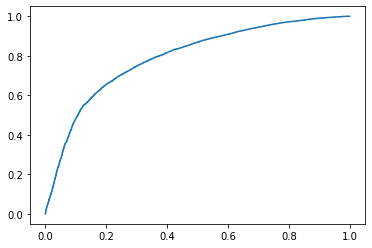

In [74]:
import matplotlib.pyplot as plt

plt.plot(tpr, fpr)
plt.show()